# **Garbage Classifier Performance Metrics**
### **ENEL 645**
#### **Group 5: Destin Saba, Cole Cathcart**

This notebook contains metrics and visualizations for analyzing the test set performance of a trained garbage classification model. The intended test set to use with this notebook is the CVPR_2024_dataset_Test, but other datasets will also work. The model itself is NOT trained in this notebook; please see the 'garbageClassifier.py' file for the code to train the model or download the saved model via the link found in the README file.

#### Instructions to run the notebook
1. To reduce code duplication, this notebook imports some classes directly from our classifier model. Please ensure that 'garbageClassifier.py' is in the same directory as this notebook before running.

2. Edit or uncomment the TEST_PATH variable below to point to the location of the dataset you wish to test the model on. This notebook assumes the directory is already organized into subdirectories based on class label.
3. Edit or uncomment the MODEL_PATH variable below to point to the location of the model.pth file. A model which was trained on the TALC cluster is available to download from google drive (link is in the README file).
4. Run all cells.

In [43]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn
import numpy as np
import os
from PIL import Image
from transformers import DistilBertTokenizer, DistilBertModel
from torchvision.models import ResNet18_Weights
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

#importing custom classes
from garbageClassifier import MultimodalGarbageDataset, MultimodalGarbageClassifier

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [26]:
# Set path for test data and best model depending on where the notebook is
# being run

# from google.colab import drive
# drive.mount('/content/drive')
TEST_SET_PATH = "/content/drive/MyDrive/CVPR_2024_dataset_Test"
MODEL_PATH = "/content/drive/MyDrive/best_multimodal_model.pth"

# TEST_PATH = "/work/TALC/enel645_2025w/garbage_data/CVPR_2024_dataset_Test"
# TEST_PATH = "/path/to/local/dataset"
# MODEL_PATH = "./best_model.pth"


We need to set up the test set and some other parameters before evaluation:

In [34]:
# Test set transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 24

# Create datasets
test_ds = MultimodalGarbageDataset(
    TEST_SET_PATH, tokenizer, max_len, transform=test_transform)

# Create data loaders
test_ld = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2)

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        correct = 0
        total = 0
        for batch in test_loader:
            # Move data to device
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            _, predicted = torch.max(outputs.data, 1)

            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total

    # Create classification report
    class_names = ['Black', 'Blue', 'Green', 'TTR']
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, report, cm, all_preds, all_labels

Now we can load in the previously-trained best model for evaluation:

In [39]:
# Load in the best model
best_model = MultimodalGarbageClassifier(num_classes=4).to(device)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))

# Evaluate
print("\nEvaluating multimodal model...")
accuracy, report, cm, all_preds, all_labels = evaluate_model(best_model, test_ld, device)
print(f"Multimodal Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(report)


Evaluating multimodal model...
Multimodal Model Accuracy: 84.99%

Classification Report:
{'Black': {'precision': 0.790625, 'recall': 0.7280575539568346, 'f1-score': 0.7580524344569288, 'support': 695.0}, 'Blue': {'precision': 0.837979094076655, 'recall': 0.8858195211786372, 'f1-score': 0.8612354521038496, 'support': 1086.0}, 'Green': {'precision': 0.9538258575197889, 'recall': 0.904881101376721, 'f1-score': 0.928709055876686, 'support': 799.0}, 'TTR': {'precision': 0.8194130925507901, 'recall': 0.852112676056338, 'f1-score': 0.8354430379746836, 'support': 852.0}, 'accuracy': 0.8499417249417249, 'macro avg': {'precision': 0.8504607610368085, 'recall': 0.8427177131421326, 'f1-score': 0.845859995103037, 'support': 3432.0}, 'weighted avg': {'precision': 0.8507507244110815, 'recall': 0.8499417249417249, 'f1-score': 0.8496457304581144, 'support': 3432.0}}


Finally, we create some visualizaions to aid in analysis:

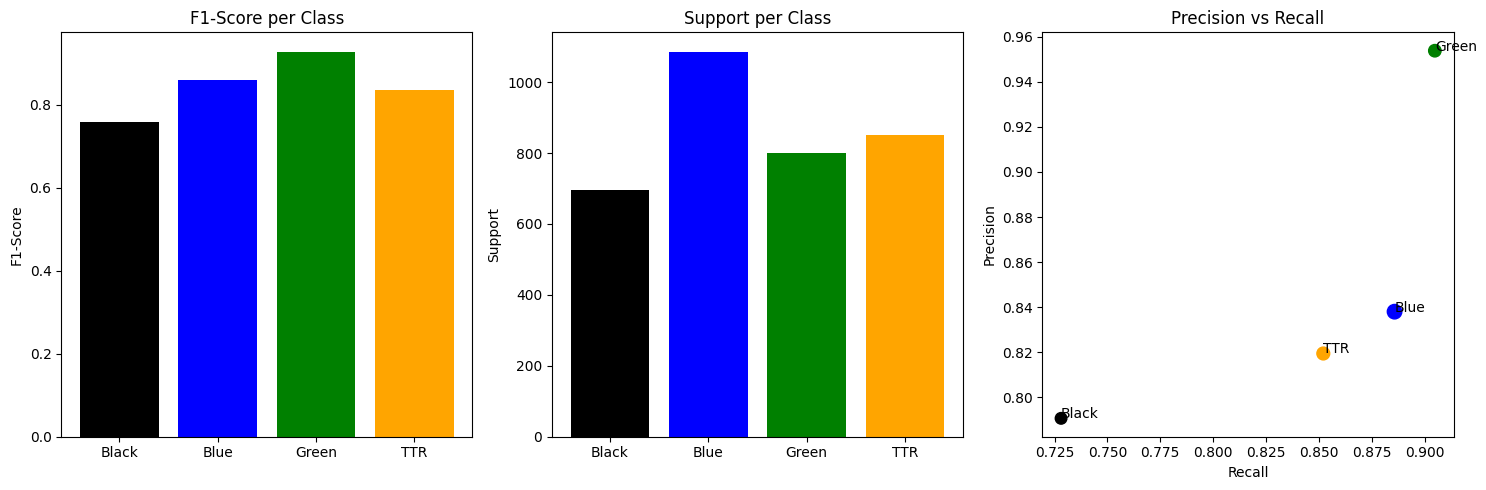

In [40]:
# Extract info from report
class_names = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
precision = [report[class_name]['precision'] for class_name in class_names]
recall = [report[class_name]['recall'] for class_name in class_names]
f1_score = [report[class_name]['f1-score'] for class_name in class_names]
support = [report[class_name]['support'] for class_name in class_names]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1-score plot
axes[0].bar(class_names, f1_score, color=['black', 'blue', 'green', 'orange'])
axes[0].set_title('F1-Score per Class')
axes[0].set_ylabel('F1-Score')

# Support plot
axes[1].bar(class_names, support, color=['black', 'blue', 'green', 'orange'])
axes[1].set_title('Support per Class')
axes[1].set_ylabel('Support')

# Precision vs Recall plot
axes[2].scatter(recall, precision, color=['black', 'blue', 'green', 'orange'], s=np.array(support) / 10)  # Size by support
axes[2].set_title('Precision vs Recall')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
# Add class name labels to points
for i, txt in enumerate(class_names):
    axes[2].annotate(txt, (recall[i], precision[i]))



# Adjust layout and show the plot
plt.tight_layout()
plt.show()

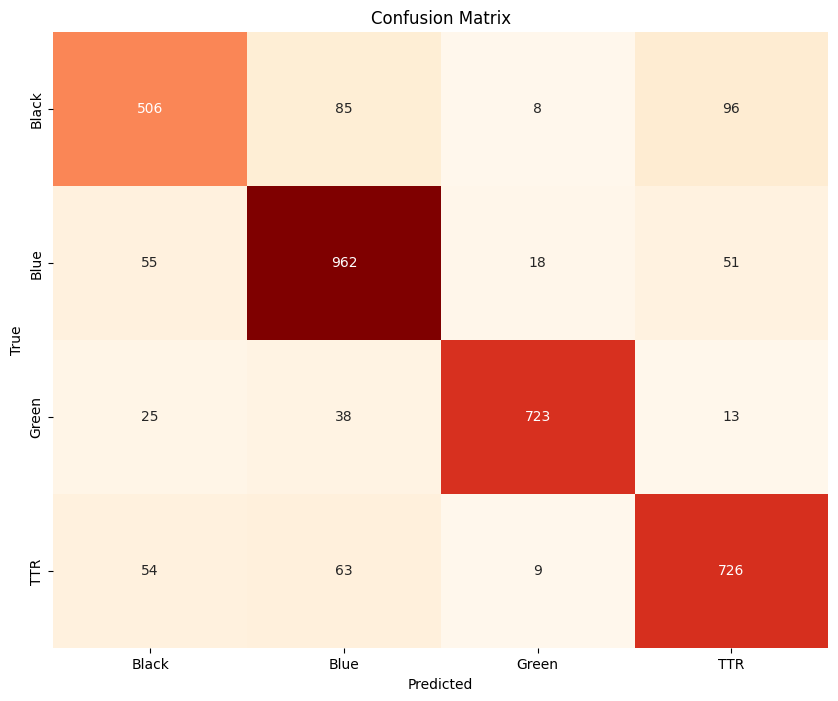

In [37]:
# Confusion matrix
class_names = ['Black', 'Blue', 'Green', 'TTR']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [47]:
# ROC curve per-class



# Analysis
